In [1]:
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch

from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt


In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-5', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--model-name', 'dentategyrus_model.cpt',
                               '--exp-name', 'CohAE_dentategyrus',
                               '--device', 'cuda:0',
                               '--gumbsoft_tau', '8',
                               '--nb_g_src', "X",
                               '--n_raw_gene', '2000',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("OPC", "OL")]
k_cluster = "clusters"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
        
    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [6]:
adata = scv.datasets.dentategyrus()
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.9 0.1]
Filtered out 11019 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:14) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 2930 × 2000
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:05) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)


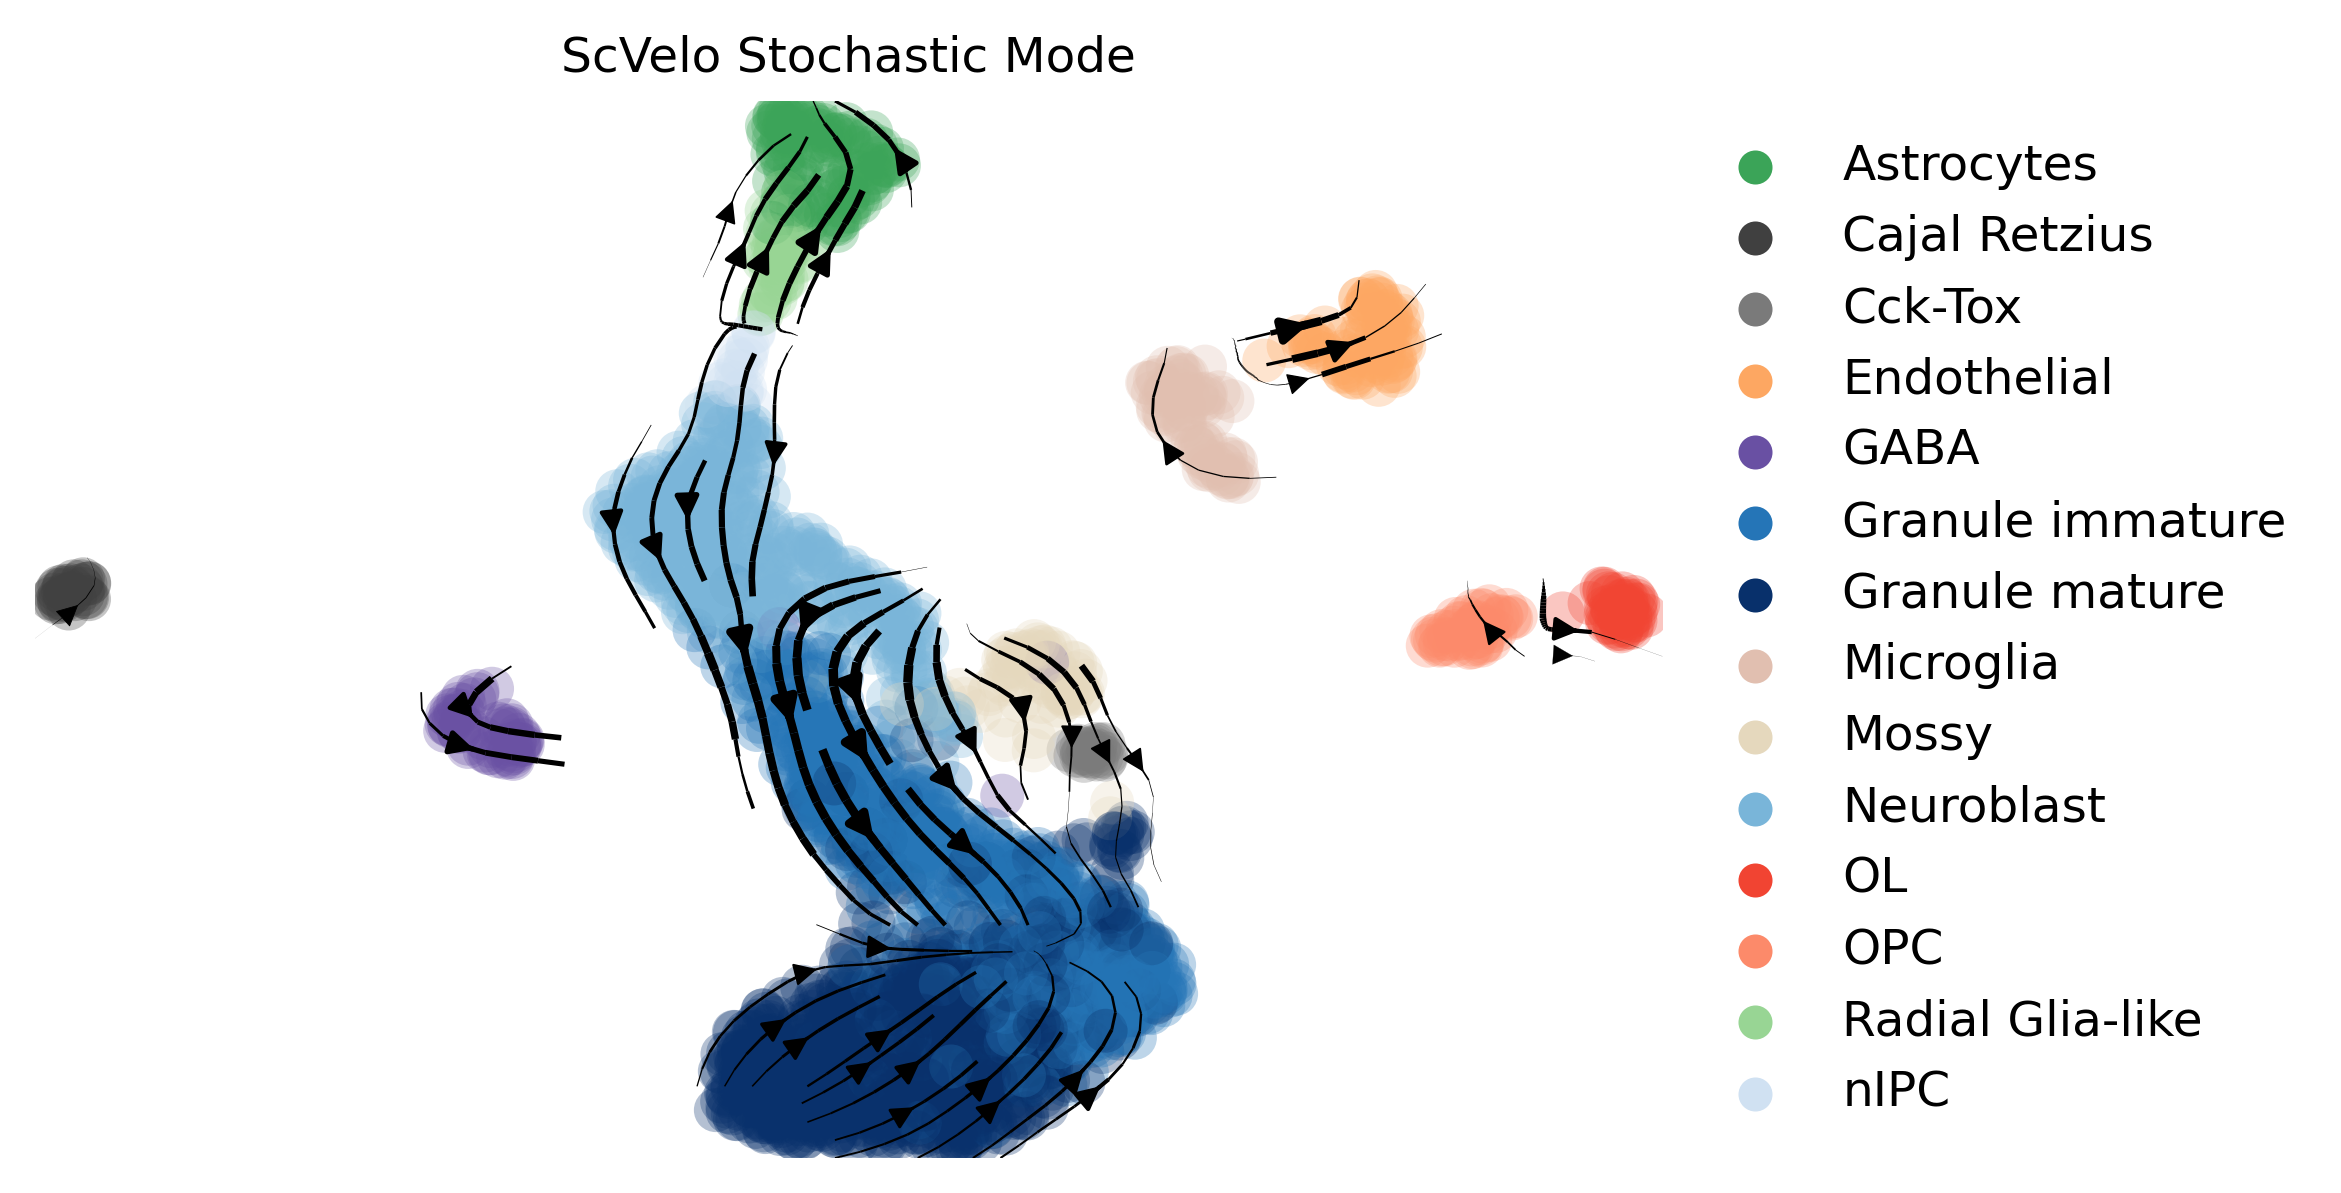

# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.0}
Total Mean: nan
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.5085378}
Total Mean: 0.5085378289222717
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): -0.8861011346479906}
Total Mean: -0.8861011346479906
# In-cluster Coherence
{'Astrocytes': 0.8558933, 'Cajal Retzius': 0.9876432, 'Cck-Tox': 0.9481789, 'Endothelial': 0.9474042, 'GABA': 0.90869683, 'Granule immature': 0.8450072, 'Granule mature': 0.80969536, 'Microglia': 0.9754837, 'Mossy': 0.89986753, 'Neuroblast': 0.9308812, 'OL': 0.9506476, 'OPC': 0.92203844, 'Radial Glia-like': 0.89049774, 'nIPC': 0.94443244}
Total Mean: 0.9154548048973083
# In-cluster Confidence
{'Astrocytes': 0.892010415593783, 'Cajal Retzius': 0.9845344126224518, 'Cck-Tox': 0.8860587852972525, 'Endothelial': 0.8625854274322247, 'GABA': 0.8818325673947569, 'Granule immature': 0.8406926885531966, 'Granule mature': 0.8008263841967717, 'Microglia': 0.8768389931431523, 'Mossy': 0.

In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                legend_loc="right margin", 
                                vkey="stc_velocity", 
                                basis='X_umap', 
                                color=[k_cluster],
                                dpi=350, 
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 2.769459
Train Epoch: 200/20000 	Loss: 2.024123
Train Epoch: 300/20000 	Loss: 1.705662
Train Epoch: 400/20000 	Loss: 1.534840
Train Epoch: 500/20000 	Loss: 1.413643
Train Epoch: 600/20000 	Loss: 1.341897
Train Epoch: 700/20000 	Loss: 1.317300
Train Epoch: 800/20000 	Loss: 1.299133
Train Epoch: 900/20000 	Loss: 1.298512
Train Epoch: 1000/20000 	Loss: 1.278838
Train Epoch: 1100/20000 	Loss: 1.273608
Train Epoch: 1200/20000 	Loss: 1.268090
Train Epoch: 1300/20000 	Loss: 1.266828
Train Epoch: 1400/20000 	Loss: 1.259184
Train Epoch: 1500/20000 	Loss: 1.256503
Train Epoch: 1600/20000 	Loss: 1.254962
Train Epoch: 1700/20000 	Loss: 1.254723
Train Epoch: 1800/20000 	Loss: 1.247902
Train Epoch: 1900/20000 	Loss: 1.242165
Train Epoch: 2000/20000 	Loss: 1.238206
Train Epoch: 2100/20000 	Loss: 1.235359
Train Epoch: 2200/20000 	L

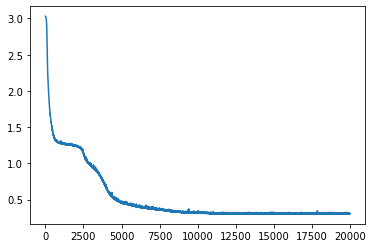

In [8]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_dentategyrus_pojection.png


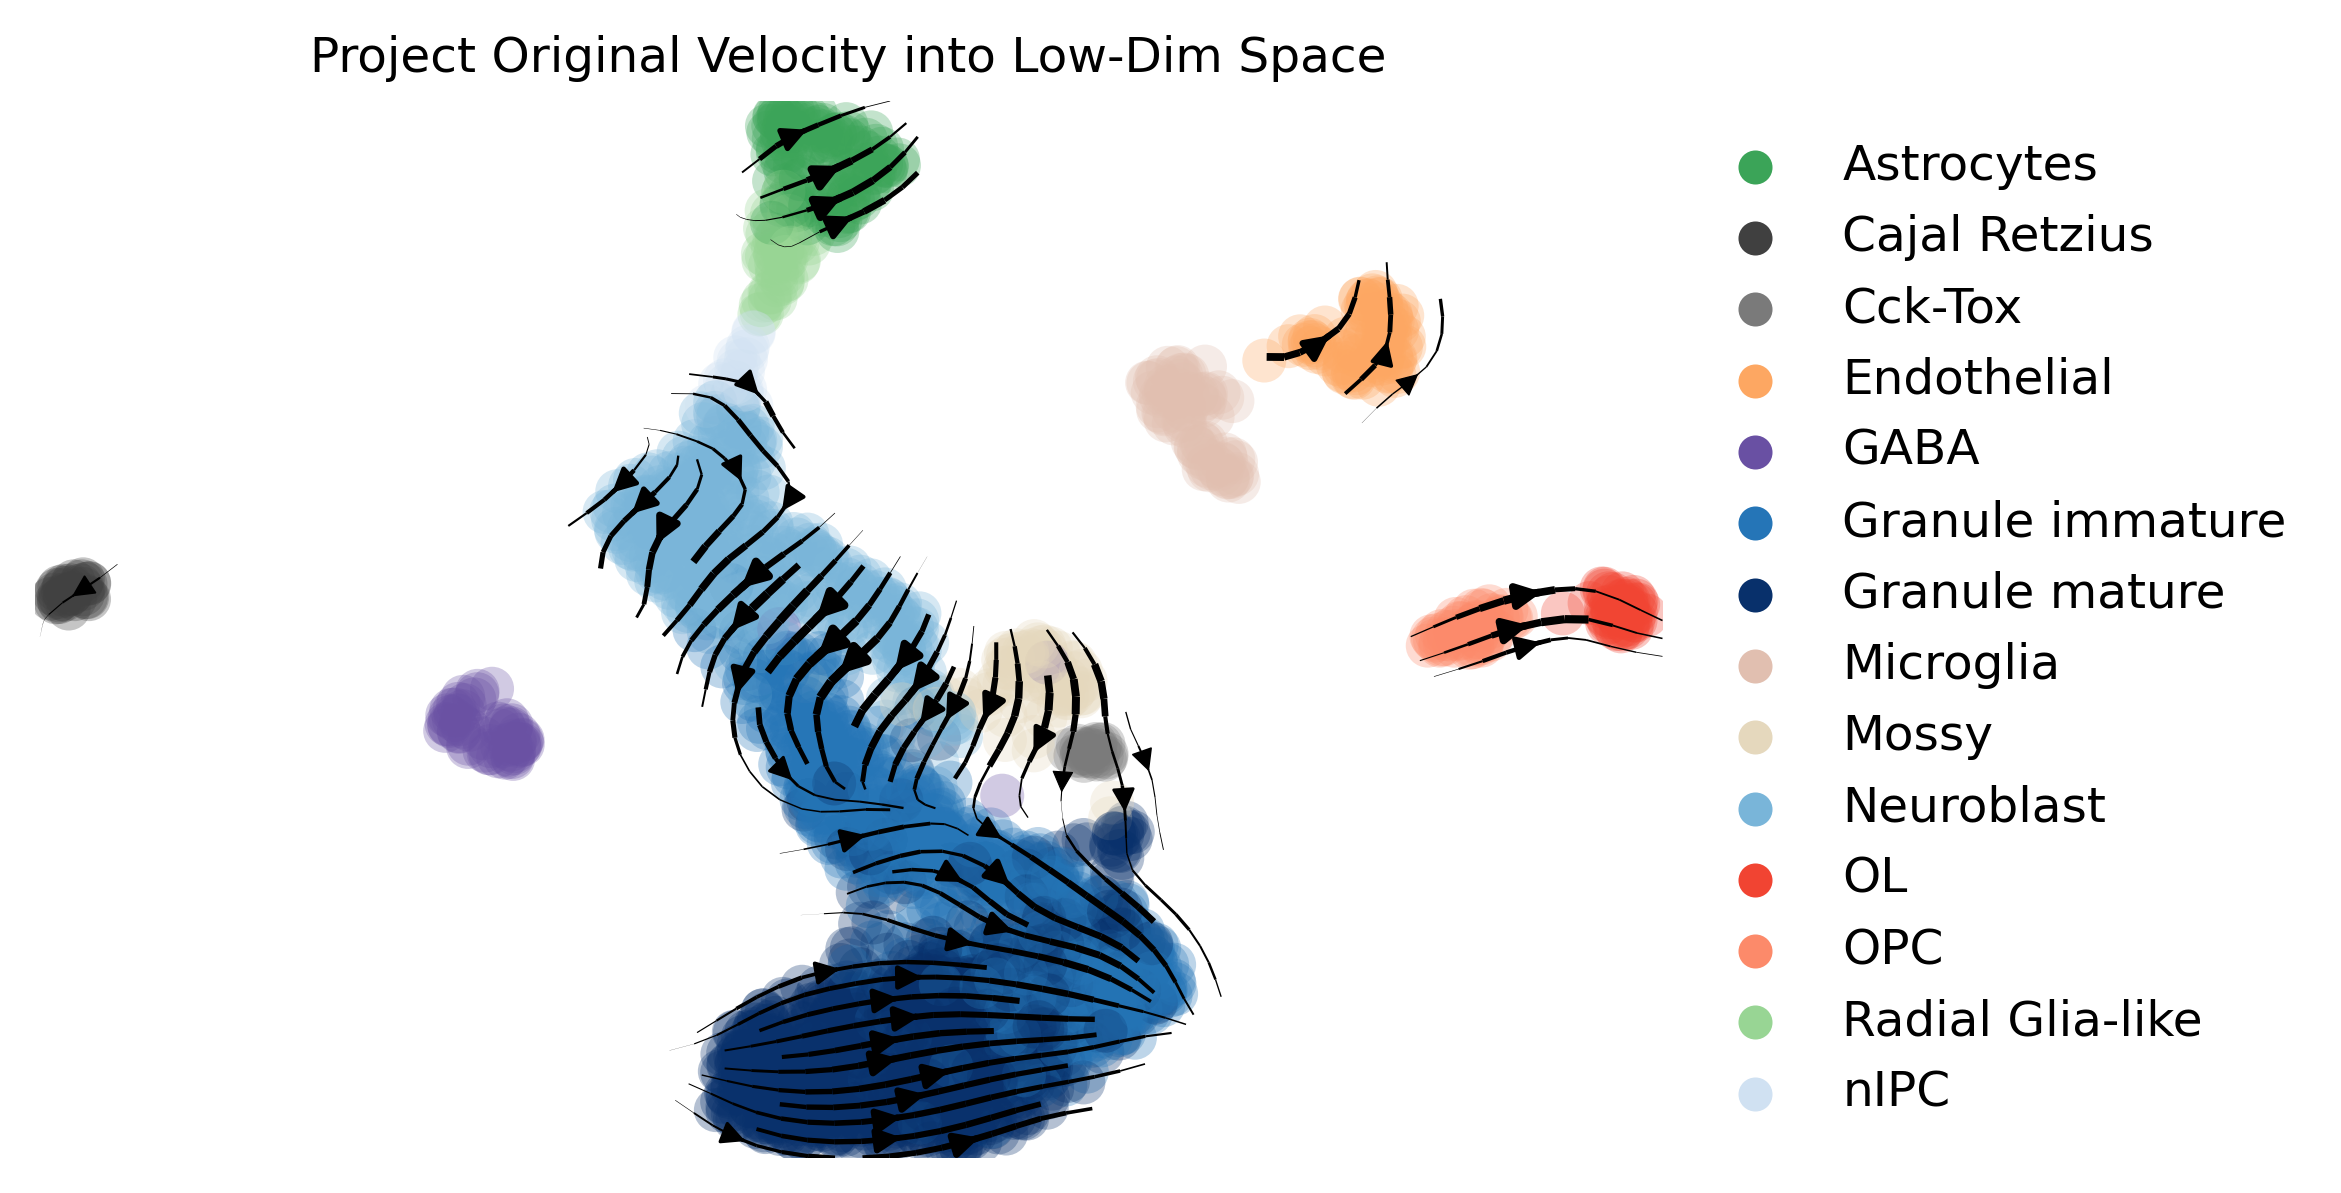

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('OPC', 'OL'): 0.9153819}
Total Mean: 0.915381908416748
# Cross-Boundary Velocity Coherence (A->B)
{('OPC', 'OL'): 0.9999725}
Total Mean: 0.9999725222587585
# Cross-Boundary Direction Correctness (A->B)
{('OPC', 'OL'): 0.9204153909825652}
Total Mean: 0.9204153909825652
# In-cluster Coherence
{'Astrocytes': 0.9999948, 'Cajal Retzius': 0.99999684, 'Cck-Tox': 0.999994, 'Endothelial': 0.99999243, 'GABA': 0.9999966, 'Granule immature': 0.999986, 'Granule mature': 0.9999834, 'Microglia': 0.99999756, 'Mossy': 0.9999938, 'Neuroblast': 0.99999124, 'OL': 0.99999666, 'OPC': 0.99999416, 'Radial Glia-like': 0.9999856, 'nIPC': 0.9999852}
Total Mean: 0.9999920725822449
# In-cluster Confidence
{'Astrocytes': 0.9999944532910983, 'Cajal Retzius': 0.9999965289059807, 'Cck-Tox': 0.9999871916241116, 'Endothelial': 0.

In [9]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        _, gamma, _ = leastsq_pt(s, u, 
                                    device=device, 
                                    fit_offset=True, 
                                    perc=[5, 95]
                                    )
        v = (u - gamma * s).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis="X")
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, legend_loc='right_margin', vkey="new_velocity", basis='X_umap', color=                                     [k_cluster],
                                    title="Project Original Velocity into Low-Dim Space", smooth=0.5,
                                    dpi=350,
                                    save='dentategyrus_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
exp(adata, exp_metrics)

In [10]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)